## Analysis of container ship emission ins Europe

Based on tracking data from Automated Information System (AIS) which commercial ships are obliged to have on board.

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import geopy.distance
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize

In [5]:
current_directory = os.path.abspath(".")
relative_path = "data/2019_AIS.csv"
full_file_path = os.path.join(current_directory, relative_path)

ais = pd.read_csv(full_file_path)

In [6]:
ais

,IMO,TIME,SOG,LONGITUDE,LATITUDE,E_CO2_kg
0,9762338,2019-02-15 07:00:00,18.080000,6.514613,53.863128,19910.666515
1,9632143,2019-10-16 04:00:00,19.000000,109.281667,9.013333,15908.133589
2,9619995,2019-11-30 19:00:00,17.800000,105.536183,3.286633,18996.828702
3,9632090,2019-11-02 04:00:00,18.166667,28.202400,33.084417,15992.137892
4,9632143,2019-12-29 14:00:00,10.669231,121.780000,38.746667,4136.355716
...,...,...,...,...,...,...
875995,9780445,2019-06-16 06:00:00,19.341667,100.445000,3.373333,31244.059442
875996,9783502,2019-02-22 10:00:00,10.836364,118.088333,38.930000,4980.821063
875997,9839466,2019-02-27 00:00:00,0.135019,128.570233,34.947090,1925.230500
875998,9778806,2019-01-11 04:00:00,21.800000,5.895000,54.158333,32498.403678


In [9]:
ais['TIME'] = pd.to_datetime(ais['TIME'])

In [10]:
ais['E_CO2_t'] = ais['E_CO2_kg'] / 1000

In [11]:
# number of ships
len(set(list(ais['IMO'])))

100

In [13]:
start_date = ais['TIME'].min().strftime('%Y-%m-%d')
end_date = ais['TIME'].max().strftime('%Y-%m-%d')

print(f'The data set contains data between {start_date} and {end_date}.')

The data set contains data between 2019-01-01 and 2019-12-31.


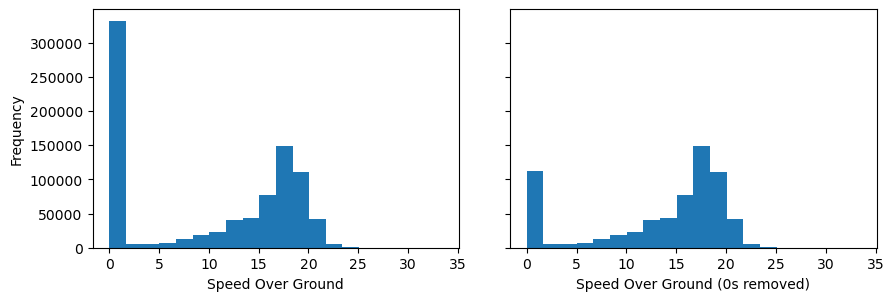

In [8]:
fig,sp = plt.subplots(1,2, sharey=True);

# normal hist
ais.SOG.plot(ax = sp[0], kind = 'hist', bins = 20)
sp[0].set_xlabel('Speed Over Ground')

# hist without zeros
ais[ais['SOG'] > 0].SOG.plot(ax = sp[1], kind = 'hist', bins = 20)
sp[1].set_xlabel('Speed Over Ground (0s removed)')

plt.tight_layout(pad=2.0)
fig.set_figheight(3)
fig.set_figwidth(10)

plt.savefig('speed_hist.png')


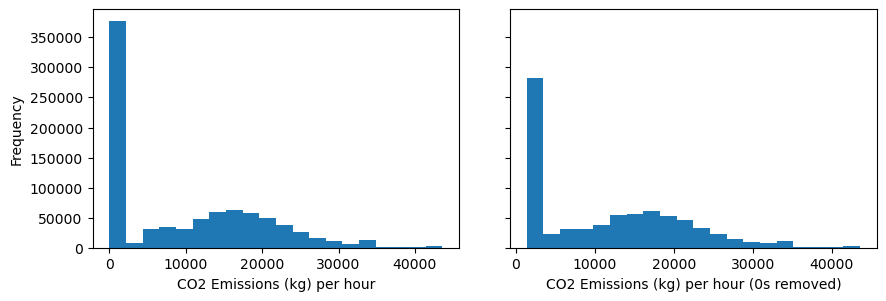

In [9]:
fig,sp = plt.subplots(1,2, sharey=True);

# normal hist
ais.E_CO2_kg.plot(ax = sp[0], kind = 'hist', bins = 20)
sp[0].set_xlabel('CO2 Emissions (kg) per hour')

# hist without zeros
ais[ais['E_CO2_kg'] > 0].E_CO2_kg.plot(ax = sp[1], kind = 'hist', bins = 20)
sp[1].set_xlabel('CO2 Emissions (kg) per hour (0s removed)')


plt.tight_layout(pad=2.0)
fig.set_figheight(3)
fig.set_figwidth(10)

plt.savefig('emission_hist.png')


### Note
It appears that ships often times do not move (speed = 0) while not necessarily emitting 0 CO2. They must have a motor running while standing in the port.

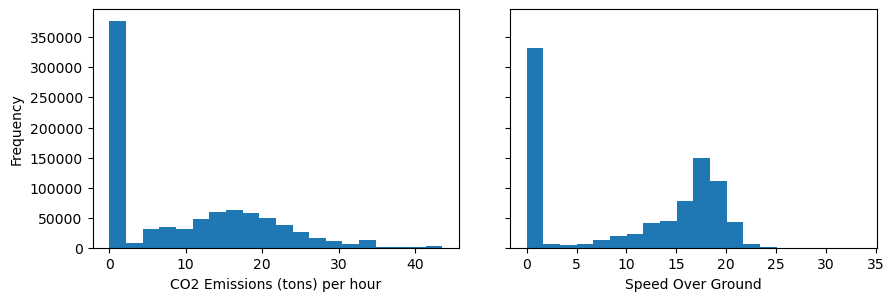

In [10]:
fig,sp = plt.subplots(1,2, sharey=True);

# emissions hist
ais.E_CO2_t.plot(ax = sp[0], kind = 'hist', bins = 20)
sp[0].set_xlabel('CO2 Emissions (tons) per hour')

# speed hist
ais.SOG.plot(ax = sp[1], kind = 'hist', bins = 20)
sp[1].set_xlabel('Speed Over Ground')

plt.tight_layout(pad=2.0)
fig.set_figheight(3)
fig.set_figwidth(10)

plt.savefig('hists.png')

### Note
Both CO2 emmissions and speed are often times at 0 or around. Apart from those zero values, CO2 emmisions appear normally distributed with mean around 17 a large standard deviation. Speed, on the other hand, has a left-skewed distribution, with ships going at speeds between 15 and 20 most of the time when not standing.

In [11]:
# share of data points with speed = 0
((ais['SOG'] == 0).sum() / len(ais)) * 100

25.11529680365297

In [12]:
# share of data points with emissions = 0
((ais['E_CO2_kg'] == 0).sum() / len(ais)) * 100

11.220319634703197

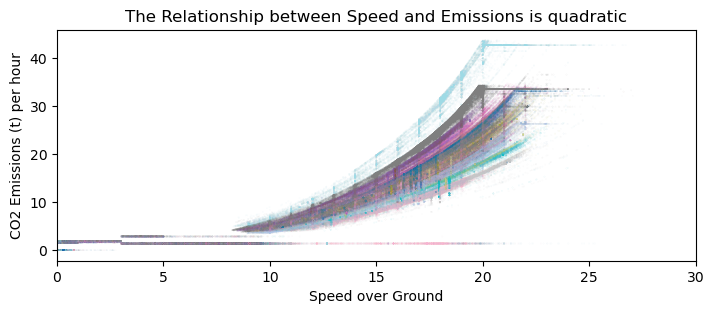

In [13]:
plt.figure(figsize = (7.5,3.5))

plt.scatter(ais.SOG, ais.E_CO2_t, s = 0.01, alpha = 0.2, c = ais.IMO, cmap = 'tab20')

plt.title('The Relationship between Speed and Emissions is quadratic')
plt.xlabel('Speed over Ground')
plt.ylabel('CO2 Emissions (t) per hour')

plt.xlim([0, 30])
plt.tight_layout(pad=2.0)

plt.savefig('scatter.png')
plt.show()


In [14]:
ports = pd.read_excel('data/PORTS.xlsx')

In [15]:
ports

,PORT_NAME,CNTR_CODE3,LONGITUDE,LATITUDE
0,PALAMOS,ESP,3.130501,41.844646
1,CHERBOURG,FRA,-1.617801,49.649769
2,DUBLIN,IRL,-6.212487,53.343665
3,STRASBOURG,FRA,7.790219,48.577101
4,PIOMBINO,ITA,10.545598,42.936886
...,...,...,...,...
8011,AGIOI OIL TERMINAL,GRC,22.116667,37.016667
8012,PORTO SANTO,PRT,-16.313650,33.060898
8013,MUGGIA,ITA,13.751923,45.606715
8014,VARNA2,BGR,27.774966,43.197109


In [16]:
ais['nearest_port'] = np.nan
ais['nearest_port_country'] = np.nan
ais['nearest_port_lon'] = np.nan
ais['nearest_port_lat'] = np.nan

In [17]:
assignment_threshold = 0.01

for i in range(len(ais)):
    
    # compute distance of ship i to all ports, in units of longitude/latitude grid
    distances = (np.sqrt((ais['LONGITUDE'][i] - ports['LONGITUDE'])**2 + (ais['LATITUDE'][i] - ports['LATITUDE'])**2))
    
    # get the shortest distance to any port
    shortest_distance = distances.min()
    
    # if this shortest ditance is smaller than my assignment threshold
    if shortest_distance < assignment_threshold:
        # get the index of the row with the shortest distance and use that index to retrieve port name and country and write it to ais
        shortest_distance_idx = distances.idxmin()
        ais.loc[i, 'nearest_port'] = ports.loc[shortest_distance_idx, 'PORT_NAME']
        ais.loc[i, 'nearest_port_country'] = ports.loc[shortest_distance_idx, 'CNTR_CODE3']
        ais.loc[i, 'nearest_port_lon'] = ports.loc[shortest_distance_idx, 'LONGITUDE']
        ais.loc[i, 'nearest_port_lat'] = ports.loc[shortest_distance_idx, 'LATITUDE']
        
    if i % 10000 == 0:
        print('Progress: ', round((i / len(ais)) * 100, 2) , '%')


Progress:  0.0 %
Progress:  1.14 %
Progress:  2.28 %
Progress:  3.42 %
Progress:  4.57 %
Progress:  5.71 %
Progress:  6.85 %
Progress:  7.99 %
Progress:  9.13 %
Progress:  10.27 %
Progress:  11.42 %
Progress:  12.56 %
Progress:  13.7 %
Progress:  14.84 %
Progress:  15.98 %
Progress:  17.12 %
Progress:  18.26 %
Progress:  19.41 %
Progress:  20.55 %
Progress:  21.69 %
Progress:  22.83 %
Progress:  23.97 %
Progress:  25.11 %
Progress:  26.26 %
Progress:  27.4 %
Progress:  28.54 %
Progress:  29.68 %
Progress:  30.82 %
Progress:  31.96 %
Progress:  33.11 %
Progress:  34.25 %
Progress:  35.39 %
Progress:  36.53 %
Progress:  37.67 %
Progress:  38.81 %
Progress:  39.95 %
Progress:  41.1 %
Progress:  42.24 %
Progress:  43.38 %
Progress:  44.52 %
Progress:  45.66 %
Progress:  46.8 %
Progress:  47.95 %
Progress:  49.09 %
Progress:  50.23 %
Progress:  51.37 %
Progress:  52.51 %
Progress:  53.65 %
Progress:  54.79 %
Progress:  55.94 %
Progress:  57.08 %
Progress:  58.22 %
Progress:  59.36 %
Progres

In [18]:
ais[ais['nearest_port_country'] == 'DEU']

,IMO,TIME,SOG,LONGITUDE,LATITUDE,E_CO2_kg,E_CO2_t,nearest_port,nearest_port_country,nearest_port_lon,nearest_port_lat
183,9839454,2019-11-17 11:00:00,12.29,8.526927,53.583150,12093.13802,12.093138,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
392,9755957,2019-01-06 15:00:00,0.00,8.531667,53.580000,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
710,9619933,2019-11-28 19:00:00,0.00,8.532633,53.580917,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
784,9632090,2019-11-24 13:00:00,0.10,8.532733,53.580800,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
989,9632167,2019-12-15 15:00:00,0.00,8.533033,53.580483,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
...,...,...,...,...,...,...,...,...,...,...,...
875059,9619983,2019-02-13 13:00:00,0.00,8.534750,53.578650,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
875107,9632105,2019-03-31 10:00:00,0.00,8.532700,53.580850,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
875198,9619933,2019-01-10 19:00:00,0.00,8.534667,53.578733,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301
875543,9619957,2019-10-06 00:00:00,0.00,8.535850,53.577483,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.53458,53.584301


In [19]:
# assigned data points
ais_assigned = ais[pd.notna(ais['nearest_port_country'])]

# european ports
ports_europe = ['BEL', 'DEU', 'DNK', 'ESP', 'FRA', 'GBR', 'GIB', 'GRC', 'ITA', 'MLT', 'NLD', 'POL', 'PRT', 'SWE']
ais_europe = ais_assigned[ais_assigned['nearest_port_country'].isin(ports_europe)]
ais_europe

,IMO,TIME,SOG,LONGITUDE,LATITUDE,E_CO2_kg,E_CO2_t,nearest_port,nearest_port_country,nearest_port_lon,nearest_port_lat
40,9776224,2019-01-04 02:00:00,0.00,1.313573,51.947970,1548.49800,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
51,9632131,2019-11-05 21:00:00,0.00,1.313333,51.948333,1476.68360,1.476684,FELIXSTOWE,GBR,1.310523,51.953560
183,9839454,2019-11-17 11:00:00,12.29,8.526927,53.583150,12093.13802,12.093138,BREMERHAVEN CONTAINER TERMINAL,DEU,8.534580,53.584301
219,9776183,2019-12-13 02:00:00,0.00,1.314980,51.945058,1548.49800,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
243,9632143,2019-08-19 20:00:00,0.00,11.860000,57.688333,1476.68360,1.476684,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
...,...,...,...,...,...,...,...,...,...,...,...
875618,9810991,2019-03-12 11:00:00,0.00,1.313322,51.948012,1548.49800,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
875722,9778832,2019-12-28 19:00:00,0.00,11.860000,57.688333,1548.49800,1.548498,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
875732,9780445,2019-10-13 21:00:00,0.00,11.860000,57.688333,1548.49800,1.548498,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
875874,9632117,2019-01-31 02:00:00,0.00,8.534400,53.579033,1476.68360,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.534580,53.584301


In [20]:
# compute number of data points, sum of emissions and mean of emissions by city
ais_europe_bycity = ais_europe.groupby(['nearest_port', 'nearest_port_lon', 'nearest_port_lat', 'nearest_port_country']).agg({
    'E_CO2_kg': ['count', 'sum', 'mean']
}).reset_index()

In [21]:
# reset column names
ais_europe_bycity.columns = ais_europe_bycity.columns.droplevel()
ais_europe_bycity.columns = ['Port', 'Lon', 'Lat', 'Country', 'count', 'sum', 'mean']

In [22]:
ais_europe_bycity

,Port,Lon,Lat,Country,count,sum,mean
0,ALGECIRAS,-5.417816,36.141293,ESP,32,2.092935e+05,6540.423354
1,BREMERHAVEN CONTAINER TERMINAL,8.534580,53.584301,DEU,4312,5.273634e+06,1223.013447
2,BRUNSBUTTEL,9.157500,53.889934,DEU,2,1.958216e+04,9791.080701
3,BRUNSBUTTEL ELBAHAFEN,9.166667,53.883333,DEU,18,1.551768e+05,8620.934548
4,BUTZFLETH,9.516667,53.650000,DEU,29,1.714932e+05,5913.559644
5,CORYTON,0.522808,51.511817,GBR,3,4.969941e+03,1656.647067
6,COWES HARBOUR,-1.300000,50.766667,GBR,3,1.127412e+04,3758.038509
7,CUXHAVEN,8.713335,53.864221,DEU,2,1.573374e+04,7866.869237
8,DUNKERQUE,2.178921,51.016007,FRA,282,4.464861e+05,1583.284216
9,FELIXSTOWE,1.310523,51.953560,GBR,3800,5.932840e+06,1561.273689


In [23]:
# create geometry column to plot it in gdp
geometry = [Point(lon, lat) for lon, lat in zip(ais_europe_bycity['Lon'], ais_europe_bycity['Lat'])]
ais_europe_bycity['geometry'] = geometry
geo_ais_europe_bycity = gpd.GeoDataFrame(ais_europe_bycity, geometry=geometry)

In [24]:
# get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

C:\Users\tobia\AppData\Local\Temp\ipykernel_24308\979549460.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


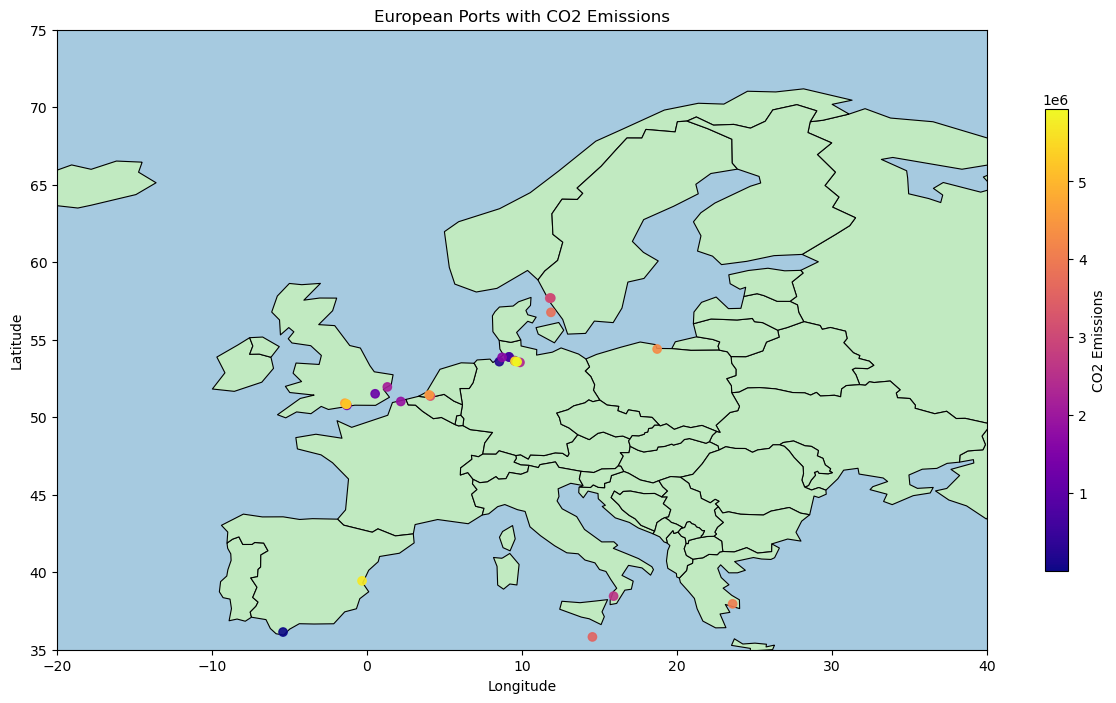

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

# plot wolrd map
europe.plot(ax=ax, color='#c1eac1', edgecolor='black', linewidth=0.8)


# Scatter plot of ports with CO2 emissions color encoded
scatter = geo_ais_europe_bycity.plot(ax=ax, c = ais_europe_bycity['sum'], cmap = 'plasma', alpha=0.9, legend = True)

# Set labels and title
plt.title('European Ports with CO2 Emissions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.xlim([-20, 40])
plt.ylim([35, 75])

ax.set_facecolor('#a6cae0')

# Customize legend
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=ais_europe_bycity['sum'].min(), vmax=ais_europe_bycity['sum'].max()))
sm._A = []  # Empty array to avoid plotting the colorbar initially
cbar = fig.colorbar(sm, ax=ax, shrink = 0.4)
cbar.set_label('CO2 Emissions')  # Set the legend title

# Show the plot
plt.show()

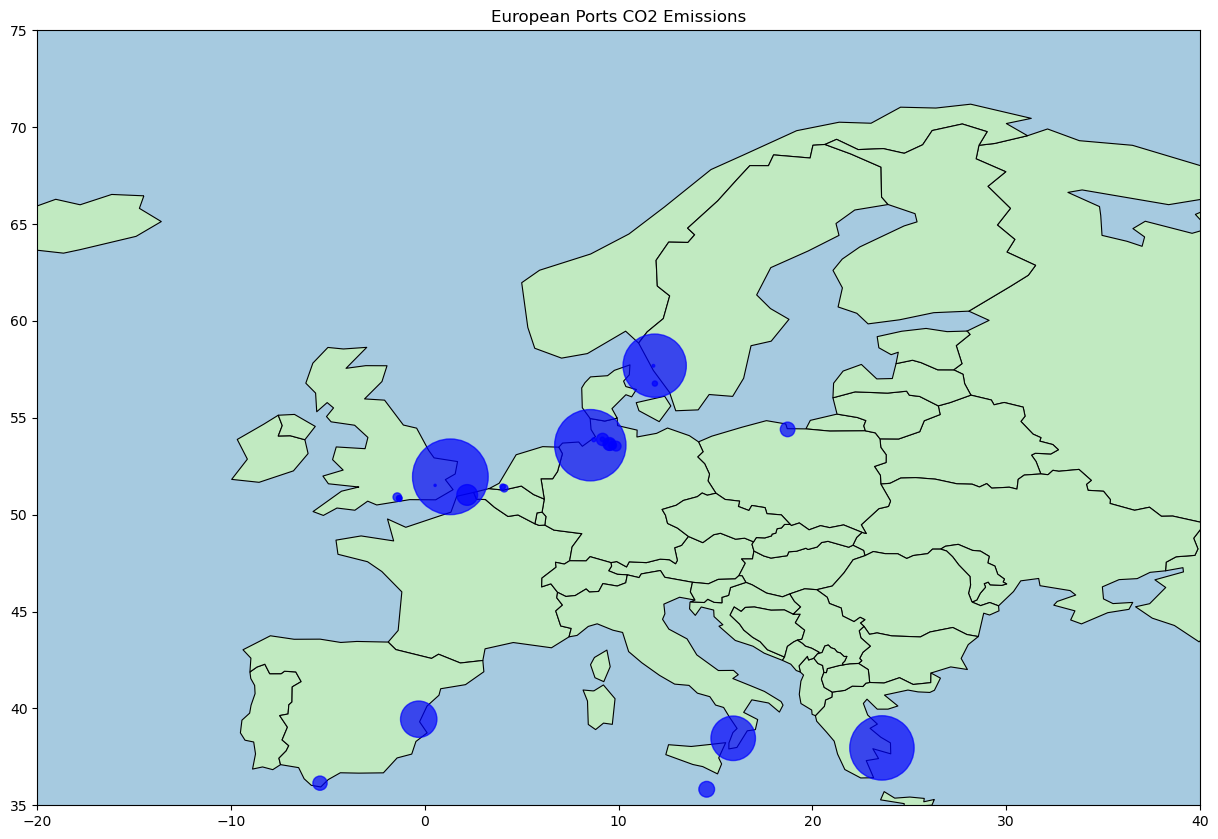

In [26]:
fig, ax = plt.subplots(figsize=(15, 30))

# plot wolrd map
europe.plot(ax=ax, color='#c1eac1', edgecolor='black', linewidth=0.8)


# Scatter plot of ports with CO2 emissions as dot size
scatter = geo_ais_europe_bycity.plot(ax=ax, c = 'Blue', markersize = geo_ais_europe_bycity['sum'] * 0.0005, alpha=0.7, legend = True)

# Set labels and title
plt.title('European Ports CO2 Emissions')
plt.xlabel('')
plt.ylabel('')

plt.xlim([-20, 40])
plt.ylim([35, 75])

ax.set_facecolor('#a6cae0')


plt.savefig('map1.png')

# Show the plot
plt.show()


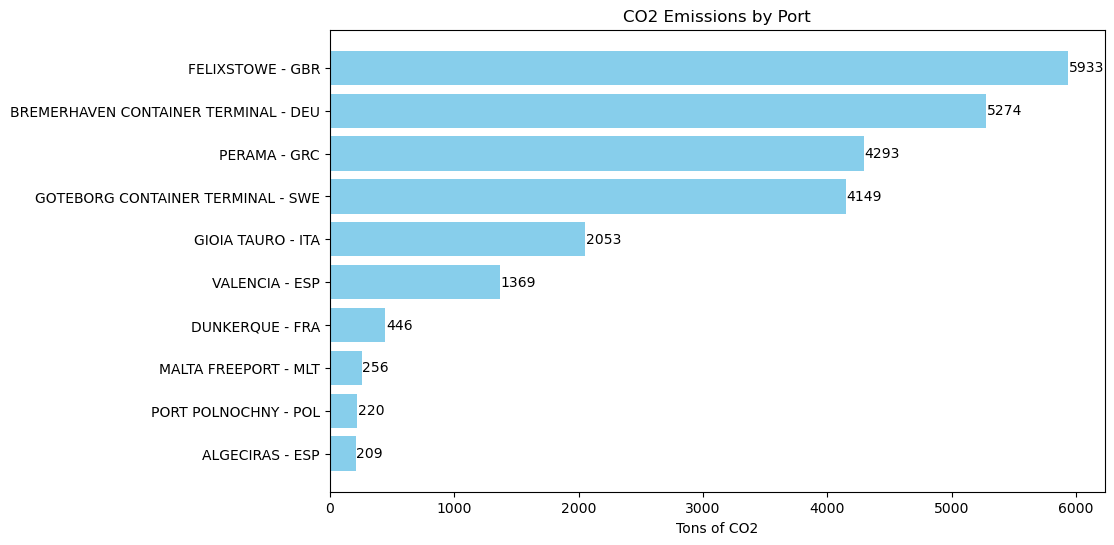

In [28]:
df = geo_ais_europe_bycity.sort_values(by='sum', ascending=False)
df = df[:10]
df['sum'] = round(df['sum'] / 1000)

# Plotting parameters
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar plot
bars = ax.barh(df['Port'] + ' - ' + df['Country'], df['sum'], color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_width()
    ax.text(yval + 5, bar.get_y() + bar.get_height()/2, f'{yval:.0f}', va='center', ha='left')

# Set labels and title
plt.xlabel('Tons of CO2')
plt.ylabel('')
plt.title('CO2 Emissions by Port')

# Invert y-axis to have the highest emissions at the top
ax.invert_yaxis()


plt.savefig('total_emissions.png')

# Show the plot
plt.show()


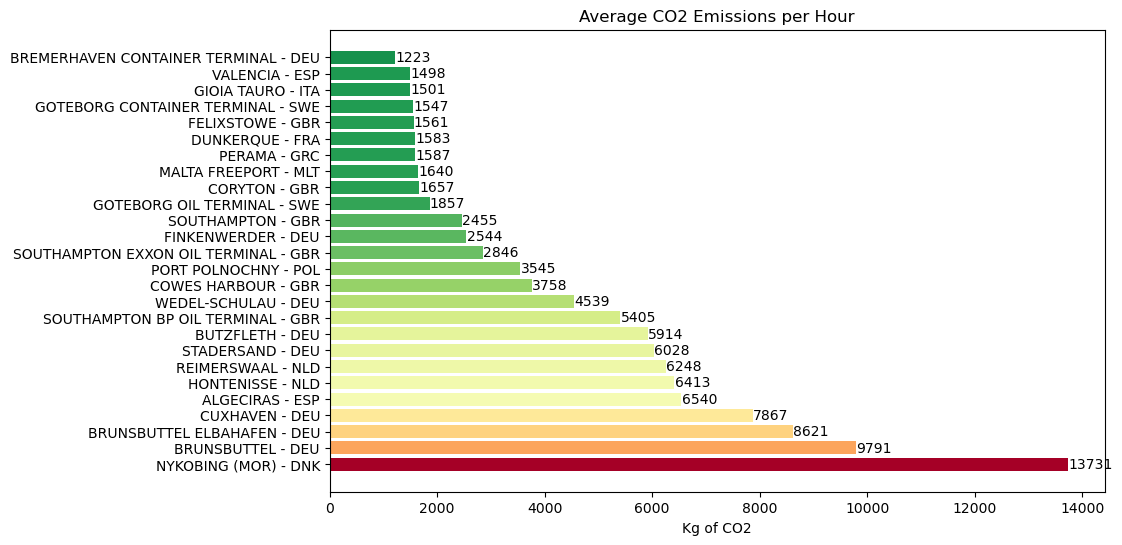

In [30]:
df = geo_ais_europe_bycity.sort_values(by='mean', ascending=False)
#df = df[:10]
df['mean'] = round(df['mean'])

# Plotting parameters
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar plot
bars = ax.barh(df['Port'] + ' - ' + df['Country'], df['mean'], color=plt.cm.RdYlGn_r(df['mean'] / df['mean'].max()))

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_width()
    ax.text(yval + 5, bar.get_y() + bar.get_height()/2, f'{yval:.0f}', va='center', ha='left')

# Set labels and title
plt.xlabel('Kg of CO2')
plt.ylabel('')
plt.title('Average CO2 Emissions per Hour')

# Invert y-axis to have the highest emissions at the top
#ax.invert_yaxis()

plt.savefig('emisssions_per_hour.png')

# Show the plot
plt.show()


Analysis made above, based on assignment just by distance of a ship to a port seems a bit sloppy. Ships seem to get assigned to ports that they are actually just passing and not entering. Hence, run analysis below, including the condition of speed = 0 to assign a ship to a port

In [31]:
standing = ais[(ais['E_CO2_kg'] > 0) & (ais['SOG'] == 0)]

In [32]:
standing = standing.groupby(['nearest_port', 'nearest_port_lon', 'nearest_port_lat', 'nearest_port_country']).agg({
    'E_CO2_kg': ['count', 'sum', 'mean']
}).reset_index()

In [33]:
standing.columns = standing.columns.droplevel()
standing.columns = ['Port', 'Lon', 'Lat', 'Country', 'count', 'sum', 'mean']

In [34]:
standing.columns

Index(['Port', 'Lon', 'Lat', 'Country', 'count', 'sum', 'mean'], dtype='object')

In [35]:
standing

,Port,Lon,Lat,Country,count,sum,mean
0,BREMERHAVEN CONTAINER TERMINAL,8.534580,53.584301,DEU,2859,4.284317e+06,1498.536880
1,CHIWAN,113.884700,22.467134,CHN,42,6.683267e+04,1591.254000
2,COLOMBO,79.842800,6.941187,LKA,118,1.849517e+05,1567.387037
3,DUNKERQUE,2.178921,51.016007,FRA,244,3.778335e+05,1548.498000
4,FELIXSTOWE,1.310523,51.953560,GBR,2897,4.424956e+06,1527.427154
5,GIOIA TAURO,15.907970,38.457623,ITA,1268,1.872435e+06,1476.683600
6,GOTEBORG CONTAINER TERMINAL,11.856275,57.688960,SWE,2238,3.418285e+06,1527.383668
7,JEBEL ALI,55.049300,25.000634,ARE,232,3.604256e+05,1553.558493
8,MALTA FREEPORT,14.541284,35.826111,MLT,112,1.730849e+05,1545.400775
9,MINA JABAL ALI,55.050000,25.016667,ARE,683,1.036207e+06,1517.140800


In [36]:
standing_europe = standing[standing['Country'].isin(ports_europe)]
standing_europe

,Port,Lon,Lat,Country,count,sum,mean
0,BREMERHAVEN CONTAINER TERMINAL,8.534580,53.584301,DEU,2859,4.284317e+06,1498.536880
3,DUNKERQUE,2.178921,51.016007,FRA,244,3.778335e+05,1548.498000
4,FELIXSTOWE,1.310523,51.953560,GBR,2897,4.424956e+06,1527.427154
5,GIOIA TAURO,15.907970,38.457623,ITA,1268,1.872435e+06,1476.683600
6,GOTEBORG CONTAINER TERMINAL,11.856275,57.688960,SWE,2238,3.418285e+06,1527.383668
8,MALTA FREEPORT,14.541284,35.826111,MLT,112,1.730849e+05,1545.400775
10,PERAMA,23.586012,37.960369,GRC,2455,3.801889e+06,1548.630876
11,PORT POLNOCHNY,18.716667,54.400000,POL,6,9.147359e+03,1524.559867
13,SOUTHAMPTON,-1.430357,50.905664,GBR,2,3.025182e+03,1512.590800
16,VALENCIA,-0.322483,39.442293,ESP,821,1.212357e+06,1476.683600


In [37]:
# create geometry column to plot it in gdp
geometry = [Point(lon, lat) for lon, lat in zip(standing_europe['Lon'], standing_europe['Lat'])]
standing_europe['geometry'] = geometry
standing_europe = gpd.GeoDataFrame(standing_europe, geometry=geometry)

C:\Users\tobia\AppData\Local\Temp\ipykernel_24308\865354025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standing_europe['geometry'] = geometry


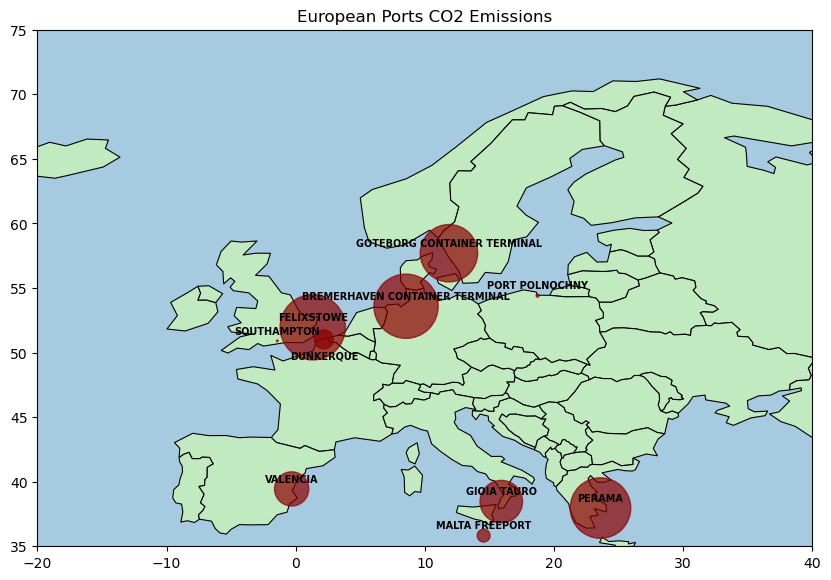

In [50]:
fig, ax = plt.subplots(figsize=(10, 20))

# plot wolrd map
europe.plot(ax=ax, color='#c1eac1', edgecolor='black', linewidth=0.8)


# Scatter plot of ports with CO2 emissions as dot size
scatter = standing_europe.plot(ax=ax, color = 'darkred', markersize = standing_europe['sum'] * 0.0005, alpha=0.7, legend = True)

for idx, row in standing_europe.iterrows():
    if row['Port'] == 'DUNKERQUE':
        ax.annotate(row['Port'], (row['Lon'], row['Lat']-2), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=7, weight = 'bold')
    else:
        ax.annotate(row['Port'], (row['Lon'], row['Lat']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=7, weight = 'bold')


# Set labels and title
plt.title('European Ports CO2 Emissions')
plt.xlabel('')
plt.ylabel('')

plt.xlim([-20, 40])
plt.ylim([35, 75])

ax.set_facecolor('#a6cae0')


plt.savefig('map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [39]:
standing_europe

,Port,Lon,Lat,Country,count,sum,mean,geometry
0,BREMERHAVEN CONTAINER TERMINAL,8.534580,53.584301,DEU,2859,4.284317e+06,1498.536880,POINT (8.53458 53.58430)
3,DUNKERQUE,2.178921,51.016007,FRA,244,3.778335e+05,1548.498000,POINT (2.17892 51.01601)
4,FELIXSTOWE,1.310523,51.953560,GBR,2897,4.424956e+06,1527.427154,POINT (1.31052 51.95356)
5,GIOIA TAURO,15.907970,38.457623,ITA,1268,1.872435e+06,1476.683600,POINT (15.90797 38.45762)
6,GOTEBORG CONTAINER TERMINAL,11.856275,57.688960,SWE,2238,3.418285e+06,1527.383668,POINT (11.85627 57.68896)
8,MALTA FREEPORT,14.541284,35.826111,MLT,112,1.730849e+05,1545.400775,POINT (14.54128 35.82611)
10,PERAMA,23.586012,37.960369,GRC,2455,3.801889e+06,1548.630876,POINT (23.58601 37.96037)
11,PORT POLNOCHNY,18.716667,54.400000,POL,6,9.147359e+03,1524.559867,POINT (18.71667 54.40000)
13,SOUTHAMPTON,-1.430357,50.905664,GBR,2,3.025182e+03,1512.590800,POINT (-1.43036 50.90566)
16,VALENCIA,-0.322483,39.442293,ESP,821,1.212357e+06,1476.683600,POINT (-0.32248 39.44229)


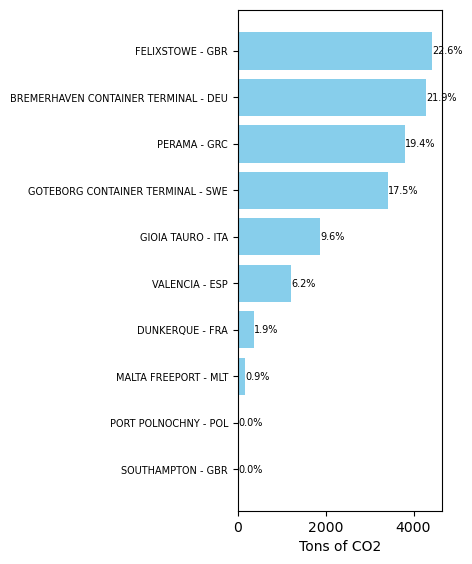

In [93]:
df = standing_europe.sort_values(by='sum', ascending=False)
df = df[:10]
df['sum'] = round(df['sum'] / 1000)

# Plotting parameters
fig, ax = plt.subplots(figsize=(5, 6))

# Create a horizontal bar plot
bars = ax.barh(df['Port'] + ' - ' + df['Country'], df['sum'], color='skyblue')

# Add % of total on top of the bars
for bar in bars:
    yval = bar.get_width()
    ax.text(yval + 5, bar.get_y() + bar.get_height()/2, '{:.1f}%'.format(((yval) / df['sum'].sum()) * 100), va='center', ha='left', fontsize = 7)

# Set labels and title
plt.xlabel('Tons of CO2')
plt.ylabel('')
#plt.title('CO2 Emissions by Port')

# Invert y-axis to have the highest emissions at the top
ax.invert_yaxis()

ax.tick_params(axis='y', labelsize=7) 
plt.tight_layout(pad=2.0)

plt.savefig('total_emissions.png')

# Show the plot
plt.show()


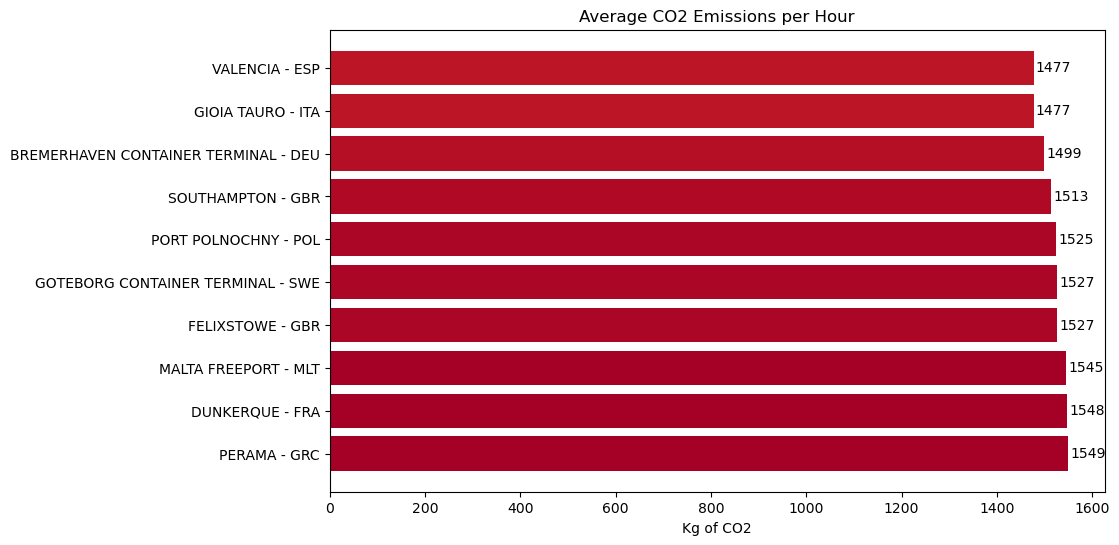

In [62]:
df = standing_europe.sort_values(by='mean', ascending=False)
#df = df[:10]
df['mean'] = round(df['mean'])

# Plotting parameters
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar plot
bars = ax.barh(df['Port'] + ' - ' + df['Country'], df['mean'], color=plt.cm.RdYlGn_r(df['mean'] / df['mean'].max()))

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_width()
    ax.text(yval + 5, bar.get_y() + bar.get_height()/2, f'{yval:.0f}', va='center', ha='left')

# Set labels and title
plt.xlabel('Kg of CO2')
plt.ylabel('')
plt.title('Average CO2 Emissions per Hour')

# Invert y-axis to have the highest emissions at the top
#ax.invert_yaxis()

plt.savefig('emisssions_per_hour.png')

# Show the plot
plt.show()


In [69]:
# share of standing emissions in europe in total emissions in data set
standing_europe['sum'].sum() / ais['E_CO2_t'].sum()

2.198941779295444

In [83]:
# total sum of standing emissions
standing_europe['sum'].sum()

19577329.835699998

In [76]:
# take ungrouped data to build a boxplot from it
standing_ungrouped = ais[ais['SOG'] == 0]
standing_ungrouped_europe = standing_ungrouped[standing_ungrouped['nearest_port_country'].isin(ports_europe)]

In [77]:
standing_ungrouped_europe

,IMO,TIME,SOG,LONGITUDE,LATITUDE,E_CO2_kg,E_CO2_t,nearest_port,nearest_port_country,nearest_port_lon,nearest_port_lat
40,9776224,2019-01-04 02:00:00,0.0,1.313573,51.947970,1548.4980,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
51,9632131,2019-11-05 21:00:00,0.0,1.313333,51.948333,1476.6836,1.476684,FELIXSTOWE,GBR,1.310523,51.953560
219,9776183,2019-12-13 02:00:00,0.0,1.314980,51.945058,1548.4980,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
243,9632143,2019-08-19 20:00:00,0.0,11.860000,57.688333,1476.6836,1.476684,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
317,9754953,2019-11-13 00:00:00,0.0,-0.325000,39.438333,1476.6836,1.476684,VALENCIA,ESP,-0.322483,39.442293
...,...,...,...,...,...,...,...,...,...,...,...
875618,9810991,2019-03-12 11:00:00,0.0,1.313322,51.948012,1548.4980,1.548498,FELIXSTOWE,GBR,1.310523,51.953560
875722,9778832,2019-12-28 19:00:00,0.0,11.860000,57.688333,1548.4980,1.548498,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
875732,9780445,2019-10-13 21:00:00,0.0,11.860000,57.688333,1548.4980,1.548498,GOTEBORG CONTAINER TERMINAL,SWE,11.856275,57.688960
875874,9632117,2019-01-31 02:00:00,0.0,8.534400,53.579033,1476.6836,1.476684,BREMERHAVEN CONTAINER TERMINAL,DEU,8.534580,53.584301


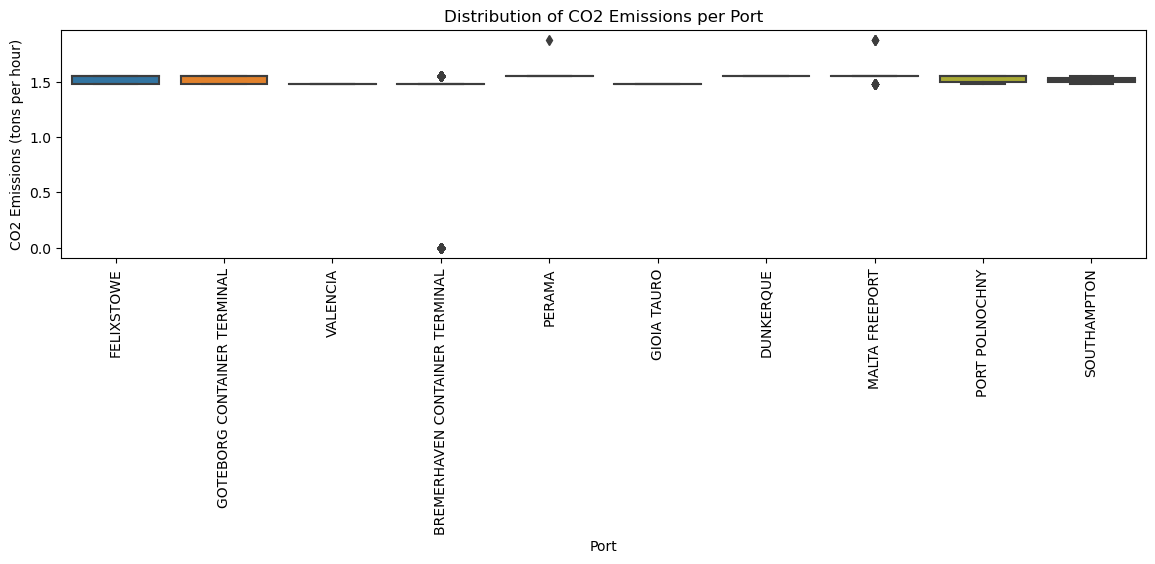

In [94]:
plt.figure(figsize=(12, 6))  
sns.boxplot(x='nearest_port', y='E_CO2_t', data=standing_ungrouped_europe)
plt.title('Distribution of CO2 Emissions per Port')
plt.xlabel('Port')
plt.ylabel('CO2 Emissions (tons per hour)')
plt.xticks(rotation=90)

plt.tight_layout(pad = 2)

plt.savefig('boxplot.png')

# Show the plot
plt.show()